In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import imshow
from PIL import Image, ImageFilter

In [239]:
os.getcwd() 

image_dir = 'C:\\Users\\CSH\\Desktop\\투빅스 프로젝트 2/train/'

for path, dir, files in os.walk(image_dir):
    print(path)
    print(dir)
    print(files) # 이렇게다 파일들로 들어가서 그안의 목록들까지 보는구나 

C:\Users\CSH\Desktop\투빅스 프로젝트 2/train/
[]
['000000000139.jpg', '000000000285.jpg', '000000000632.jpg', '000000000724.jpg', '000000000776.jpg', '000000000785.jpg', '000000000802.jpg', '000000000872.jpg', '000000000885.jpg', '000000001000.jpg']


In [240]:
train_x = []
resizing = (32, 32)

for path, dir, files in os.walk(image_dir):
    for file in files:
        image_dir = path + '/' + file 
        img = Image.open(image_dir)
        img = img.resize(resizing)
        if not img.format == "RGB": # 이미지의 포맷이 RGB가 아닐 경우, RGB로 convert 시킴
            img = img.convert("RGB")
        train_x.append(np.array(img))

In [241]:
image = train_x[0]

In [242]:
image = image.reshape([1,32,32,3])

In [243]:
imshow(image[0])

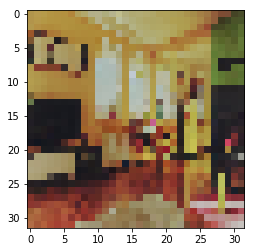

In [244]:
plt.show()

In [245]:
tg_bbox =[0.0, 13.0, 7.0, 7.0]

### CNN

In [327]:
tf.reset_default_graph()

In [328]:
x_image = tf.placeholder(dtype=tf.float32, shape=[1,32,32,3]) # 이미지 데이터의 경우 shape은 [number, height, width, channels] 순이다

In [329]:
with tf.name_scope("First_Layer") as scope: 
    w1 = tf.Variable(tf.random_normal(shape=[3,3,3,32], stddev=0.01), name = "W1") # shape !!!!!!!!!!
    L1 = tf.nn.conv2d(input= x_image, filter= w1, strides=[1,1,1,1], padding='SAME', name="L1")
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1],  strides= [1,2,2,1], padding='SAME')

In [330]:
with tf.name_scope("Second_Layer") as scope:  
    w2 = tf.Variable(tf.random_normal(shape=[3,3,32,64], stddev=0.01))
    L2 = tf.nn.conv2d(input= L1, filter= w2, strides=[1,1,1,1], padding='SAME') 
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1],  strides= [1,2,2,1], padding='SAME')

In [331]:
L2

<tf.Tensor 'Second_Layer/MaxPool:0' shape=(1, 8, 8, 64) dtype=float32>

In [332]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
feature_map = sess.run(L2, feed_dict={x_image: image})[0]

In [333]:
feature_map.shape

(8, 8, 64)

### RPN

In [334]:
window = tf.get_variable(shape=[3,3,64,64], name='window')
intermediate_layer = tf.nn.conv2d(input=L2, filter = window, strides=[1,1,1,1], padding='VALID')
intermediate_layer = tf.nn.sigmoid(intermediate_layer)

In [335]:
intermediate_layer

<tf.Tensor 'Sigmoid:0' shape=(1, 6, 6, 64) dtype=float32>

In [336]:
filter_1 = tf.get_variable(shape=[1,1,64,6], name='filter_1') # cls 2 + reg 4 = 6 (the number of filters)
output = tf.nn.conv2d(input=intermediate_layer, filter=filter_1, strides=[1,1,1,1], padding='VALID')
#output = tf.nn.sigmoid(output) # 렐루 하는거 맞니 ? 

In [337]:
output

<tf.Tensor 'Conv2D_1:0' shape=(1, 6, 6, 6) dtype=float32>

In [338]:
conv_ratio= image.shape[1]/feature_map.shape[1]
width= conv_ratio *3 # 윈도우에 매칭되는 이미지상 크기를 구하는과정임. 윈도우 가로세로 길이가 3이기에 3을 곱해줌 

In [339]:
anchor_list = []

In [340]:
output_width = feature_map.shape[1]-2
anchor_list = [] # anchor_list를 어떻게 tf graph 안에 넣지 ???>...... 저 밑에 과정들도 언제다넣냐 ..//
for i in range(output_width):
    for j in range(output_width):
        anchor_list.append([i*conv_ratio, j*conv_ratio, width, width])

In [341]:
def get_iou(tf,anchor):
    if tf[0]<anchor[0]: # tf가 x값이 더 작을때; tf가 더 왼쪽에 있을떄 (매트릭스기준)
        intersection_width = tf[0]+tf[2]-anchor[0]
    elif tf[0]>anchor[0]:
        intersection_width = anchor[0]+anchor[2]-tf[0]
    else:
        intersection_width=tf[2]
    if intersection_width<=0:
        intersection_width=0
    
    if tf[1]>anchor[1]:#  tf가 y값이 더 클때; tf가 더 밑에 있을때 (매트릭스기준)
        intersection_height = anchor[1]+anchor[3] -tf[1]
    elif tf[1]<anchor[1]:
        intersection_height = tf[1]+tf[3] -anchor[1]
    else:
        intersection_height=tf[3]
    if intersection_height<=0:
        intersection_height=0
    intersection = intersection_width*intersection_height
    union = tf[2]*tf[3] + anchor[2]*anchor[3]-intersection
    return(intersection/union)

In [342]:
get_iou(anchor_list[0],anchor_list[4])

0.0

In [343]:
pos_anchor=[]
for anchor in anchor_list:
    if get_iou(anchor,tg_bbox)>=0.7:
        pos_anchor.append(anchor)
pos_anchor

[[0.0, 8.0, 12.0, 12.0], [0.0, 12.0, 12.0, 12.0]]

In [344]:
def position_on_feature_map(list_1): # cnn의 feature_map에서 3x3을 한번 또 거친 매트릭스상의 위치를 구하는 과정이다. 
    result=[]
    for t in list_1:
        result.append([t[0]/conv_ratio, t[1]/conv_ratio])
    return(result)

In [345]:
position_on_feature_map(pos_anchor) # output을 텐서에서 넘파이로 꺼내온다음 로스를 구해야할듯 ! 

[[0.0, 2.0], [0.0, 3.0]]

In [346]:
t=tf.zeros([1], dtype=tf.float32)
for locs in position_on_feature_map(pos_anchor):
    a = tf.cast(locs[0], tf.int32)
    b = tf.cast(locs[1], tf.int32)
    pos_prob = tf.cast(output[0][a][b][0], tf.float32)
    neg_prob = tf.cast(output[0][a][b][1], tf.float32)
    cross_entr = tf.exp(pos_prob) / (tf.exp(pos_prob)+tf.exp(neg_prob))
    t += cross_entr
t

<tf.Tensor 'add_11:0' shape=(1,) dtype=float32>

In [347]:
loss_cls = -tf.log(t) 

In [348]:
output

<tf.Tensor 'Conv2D_1:0' shape=(1, 6, 6, 6) dtype=float32>

def smoothing (x): # 이거 텐서안으로 어떻게 넣어 ????????????
    t=[]
    for i in range(x.shape.as_list()[0]):
        if tf.abs(x[i])<1:
            t.append(0.5*x[i]**2)
        else:
            t.append(tf.abs(x[i])-0.5)
    
    return(x)

def smoothing (x): # 이거 텐서안으로 어떻게 넣어 ????????????
    t=[]
    for i in range(x.shape.as_list()[0]):
        t.append(tf.cond(tf.abs(x[i])<1, lambda : 0.5*x[i]**2, lambda : tf.abs(x[i])-0.5))
       x =  tf.scatter_update(x, [i], [tmp]) 
    return(t)

smoothing(output[0][0][2][2:] - tf_bbox)

In [349]:
tf_bbox = tf.placeholder(dtype=tf.float32, shape=[4])

t1 =tf.zeros([1], dtype=tf.float32)
for locs in position_on_feature_map(pos_anchor):
    a = tf.cast(locs[0], tf.int32)
    b = tf.cast(locs[1], tf.int32)
    t1 += tf.cast((output[0][a][b][2:] - tf_bbox)**2, tf.float32) # reg loss 함수 제대로 바꿔봐야함 ! ! 
loss_reg = tf.reduce_sum(t1)

In [350]:
loss = tf.add(loss_reg, loss_cls)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
training= optimizer.minimize(loss=loss)

In [351]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for locs in position_on_feature_map(pos_anchor):
    a = tf.cast(locs[0], tf.int32)
    b = tf.cast(locs[1], tf.int32)
    print(sess.run(output[0][a][b][2:] , feed_dict={x_image:image, tf_bbox: tg_bbox}))

[-0.48951396 -1.7347106  -0.43495536  1.382464  ]
[-0.44212168 -1.7506497  -0.4472074   1.4205359 ]


In [352]:
for i in range(1000):
    sess.run(training, feed_dict={x_image:image, tf_bbox:tg_bbox})
    if i%100 ==0:
        print(sess.run(loss, feed_dict={x_image:image, tf_bbox: tg_bbox}))

[12.510825]
[-0.6747666]
[-0.6842097]
[-0.68725073]
[-0.68874925]
[-0.6896411]
[-0.6902325]
[-0.6906533]
[-0.690968]
[-0.6912122]


In [356]:
# 회귀 잘 됏는지 확인 
for locs in position_on_feature_map(pos_anchor):
    a = tf.cast(locs[0], tf.int32)
    b = tf.cast(locs[1], tf.int32)
    print('Probability for Pos :', sess.run(tf.exp(pos_prob) / (tf.exp(pos_prob)+tf.exp(neg_prob)) , feed_dict={x_image:image, tf_bbox: tg_bbox})) 
    print('Probability for Neg :',sess.run(tf.exp(neg_prob) / (tf.exp(pos_prob)+tf.exp(neg_prob)) , feed_dict={x_image:image, tf_bbox: tg_bbox})) 
    print('Coordinates of Bbox :',sess.run(output[0][a][b][2:] , feed_dict={x_image:image, tf_bbox: tg_bbox}), '\n') 

Probability for Pos : 0.9982598
Probability for Neg : 0.0017402091
Coordinates of Bbox : [1.4901161e-08 1.3000000e+01 7.0000000e+00 7.0000000e+00] 

Probability for Pos : 0.9982598
Probability for Neg : 0.0017402091
Coordinates of Bbox : [1.4901161e-08 1.3000000e+01 7.0000000e+00 7.0000000e+00] 



In [357]:
print(sess.run(tf_bbox, feed_dict={x_image:image, tf_bbox: tg_bbox})) # 이 값이 나와야하는데 .. 

[ 0. 13.  7.  7.]


In [ ]:
# 180521
# 1. loss function 바꾸기 // 2. cnn 모델가져오기  // 3. smoothing 제대로 하기 ! 

In [ ]:
# 이후에 fast r-cnn이랑 연결되려면 proposal받는 애의 feature_map상 위치롤 알아야함 !! 

In [ ]:
# pre-trained model 어떻게불러오는거야 공부해보자 

In [90]:
from tensorflow.contrib.slim.nets import vgg
slim = tf.contrib.slim

In [97]:
saver = tf.train.Saver()
sess=tf.Session()
saver.restore(sess, 'vgg_16.ckpt')

INFO:tensorflow:Restoring parameters from vgg_16.ckpt


NotFoundError: Tensor name "window" not found in checkpoint files vgg_16.ckpt
	 [[Node: save/RestoreV2_5 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_5/tensor_names, save/RestoreV2_5/shape_and_slices)]]

Caused by op 'save/RestoreV2_5', defined at:
  File "C:\Users\CSH\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\CSH\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\CSH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-97-d9ff9f5db21c>", line 1, in <module>
    saver = tf.train.Saver()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1139, in __init__
    self.build()
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 691, in build
    restore_sequentially, reshape)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\training\saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\CSH\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Tensor name "window" not found in checkpoint files vgg_16.ckpt
	 [[Node: save/RestoreV2_5 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_5/tensor_names, save/RestoreV2_5/shape_and_slices)]]


In [ ]:
restore = slim.assign_from_checkpoint_fn(
               'vgg_16.ckpt',
               slim.get_model_variables("vgg_16"))